In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint
from glob import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Input, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from models.densenet import build_densenet121
from sklearn.model_selection import train_test_split
from itertools import repeat
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
import re
from scripts.constants import SEED
from pprint import pprint
import tensorflow_probability as tfp
import json

In [3]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
import json


In [4]:
def predict_input_fn(fileNames,side,bands):
  
    # Read `TFRecordDatasets` 
    dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

    featuresDict = {x:tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}
    #print(featuresDict)
    # Make a parsing function
    def parse_image(example_proto):
        parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
        return parsed_features
    
    def stack_images(features):   
        channels = ['B4', 'B3', 'B2' ,'NDWI', 'AVE']
        img_chan = [features[x] for x in channels if x in ['B4', 'B3', 'B2' ]]
        ndwi_chan = [features[x] for x in channels if x in ['NDWI']]
        ave_chan = [features[x] for x in channels if x in ['AVE']]
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        # further normalization?
        img = tf.concat([img, tf.transpose(ndwi_chan)], axis= 2)
        
        ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
        img = tf.concat([img, tf.transpose(ave_chan)], axis= 2)

        return img
    
    '''
    def stack_images(features):   
        print(features.values())
        nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))    
        return nfeat
    '''
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    dataset = dataset.map(stack_images, num_parallel_calls=4) 
    #CAHNGE THIS TO TOTAL_PATCHES * PATCH PER ROW
    dataset = dataset.batch(100)

    return dataset

In [6]:
files = sorted(glob('testlocations/*.tfrecord.gz'))
mixers = sorted(glob('testlocations/*mixer.json'))
print(mixers)
images = []

for x in files:
    dataset = predict_input_fn(x, 256, ['B4', 'B3', 'B2','NDWI','AVE'])
    images.append(dataset)

for x in images:
    print(next(iter(x)).shape)
    

['testlocations/testLoc0-mixer.json', 'testlocations/testLoc1-mixer.json', 'testlocations/testLoc2-mixer.json', 'testlocations/testLoc3-mixer.json', 'testlocations/testLoc4-mixer.json', 'testlocations/testLoc5-mixer.json']
(16, 256, 256, 5)
(16, 256, 256, 5)
(16, 256, 256, 5)
(25, 256, 256, 5)
(16, 256, 256, 5)
(2, 256, 256, 5)


655360
1.0


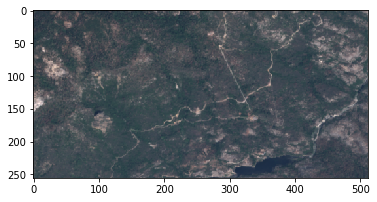

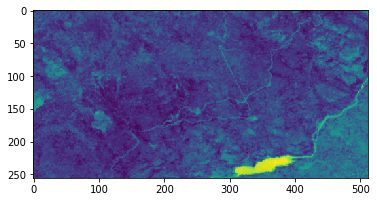

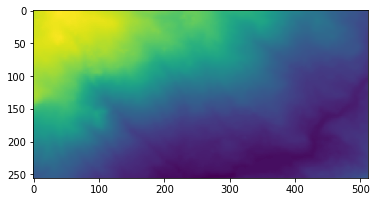

In [10]:
data = images[5]
data = next(iter(data))

def stretch_image_colorspace(img):
    max_val = np.max(img)
    return img / max_val

def stitch_patches(data, mixer):
    with open(mixer) as f:
        mixer_dict = json.load(f)
    
    patch_size = mixer_dict['patchDimensions'][0]
    n_cols = mixer_dict['patchesPerRow']
    n_rows = int(mixer_dict['totalPatches'] / n_cols)
    
    #print(patch_size, n_cols, n_rows)
    fullData = np.zeros([patch_size*n_cols, patch_size*n_rows, 5])
    for n in range(0,5):
        dataMat = np.zeros([patch_size*n_cols, patch_size*n_rows])
        z = 0
        for j in range(0,n_rows):
            for i in range(0,n_cols):
                #print("datamat shape", dataMat[i*256: (i+1)*256, j*256: (j+1)*256 ].shape)
                #print("i", i)
                #print("j", j)
                dataMat[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size ] = np.squeeze(data[z, :, :, n])
                z += 1
        fullData[:,:,n] = dataMat

    fullData[:,:,0:3] = stretch_image_colorspace(fullData[:,:,0:3])
    fullData[:,:,0:3] = np.transpose(np.array([fullData[:,:,0], fullData[:,:,1], fullData[:,:,2]]), (1, 2 ,0))
    return fullData

full_image = stitch_patches(data, mixers[5])

plt.imshow(np.fliplr(np.rot90(full_image[:,:,0:3], k=3)))
plt.figure()
print(full_image.size)
plt.imshow(np.fliplr(np.rot90(full_image[:,:,3], k=3)), cmap='viridis', interpolation='nearest')
plt.figure()
plt.imshow(np.fliplr(np.rot90(full_image[:,:,4], k=3)), cmap='viridis', interpolation='nearest')
print(np.max(full_image))

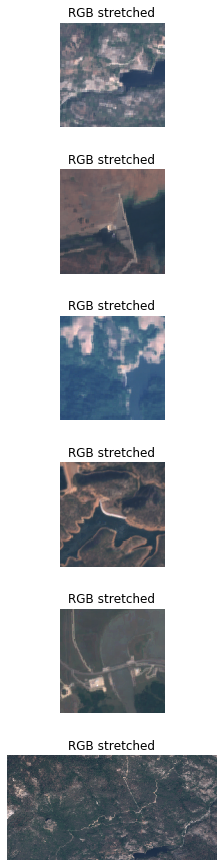

In [11]:
# ADD AVE/NDWI heatmaps?
columns = 1
rows = len(images)

fig = plt.figure(figsize=(columns+8, rows+5))
gs = gridspec.GridSpec(rows, columns,
        wspace=0.0, hspace=0.4, 
        top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
        left=0.5/(columns+1), right=1-0.2/(columns+1)) 

for j,x in enumerate(images):
    img_features = next(iter(x))
    full_image = stitch_patches(img_features, mixers[j])
    #print(full_image.size)
    #print(j)
    #good example: stretched colorspace
    #uint8 only stores 256 values :/
    ax = plt.subplot(gs[j,0])
    ax.set_title("RGB stretched")
    ax.imshow(np.fliplr(np.rot90(full_image[:,:,0:3], k=3)))
    plt.axis('off')


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 27 14:05:17 2019

@author: stephan
"""
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input
from tensorflow.keras.models import Model

# TODO: target size with variable channels
# TODO: variable number of classes
# TEMPORARY MODEL FOR TESTING PURPOSES ONLY

def build_dilated_fcn_61(train_model = True, **kwargs): 
    ## DEFINE THE ABOVE DESCRIBED MODEL HERE
    x_in = Input(batch_shape=(None, None, None, len(kwargs.get('channels')) ))
    x = Conv2D(filters=32,kernel_size=(7,7),activation='relu')(x_in) # 55, 55
    x = Conv2D(filters=32,kernel_size=(7,7), dilation_rate = 2, activation='relu')(x) # 43, 43
    x = Conv2D(filters=32,kernel_size=(5,5), activation='relu')(x) # 37, 37
    x = Conv2D(filters=32,kernel_size=(5,5), dilation_rate = 2, activation='relu')(x) # 31, 31
    x = Conv2D(filters=64,kernel_size=(5,5), activation='relu')(x) # 27, 27
    x = Conv2D(filters=64,kernel_size=(5,5), dilation_rate = 2, activation='relu')(x) # 19, 19
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 17, 17
    x = Conv2D(filters=64,kernel_size=(3,3), dilation_rate = 2, activation='relu')(x) # 13, 13
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 11, 11
    x = Conv2D(filters=64,kernel_size=(3,3), dilation_rate = 2, activation='relu')(x) # 7, 7
    x = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(x) # 5, 5
    x = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(x) # 3, 3
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 1, 1
    x = Conv2D(filters=64,kernel_size=(1,1), activation='relu')(x)
    x_out = Conv2D(filters=kwargs.get('num_classes'),kernel_size=(1,1),activation='softmax')(x)
    if train_model:
        x_out = Flatten()(x_out)
    model = Model(inputs = x_in, outputs=x_out)

    model.summary()
    return model

In [13]:
inputs = {'channels': ['B4', 'B3', 'B2', 'NDWI', 'AVE'],
         'num_classes':2}
model = build_dilated_fcn_61(train_model=False, **inputs)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 5)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    7872      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    50208     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    51264     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    102464

In [14]:
model.load_weights('checkpoints/fcn/model-dilated_fcn-2019_11_14_15_54_29-2-5.hdf5')

In [15]:
test = full_image[np.newaxis,:,:,0:5] 
preds = model.predict(test)

(1024, 1024, 5)
(1024, 1024, 5)
(1024, 1024, 5)
(1280, 1280, 5)
(1024, 1024, 5)
(512, 256, 5)


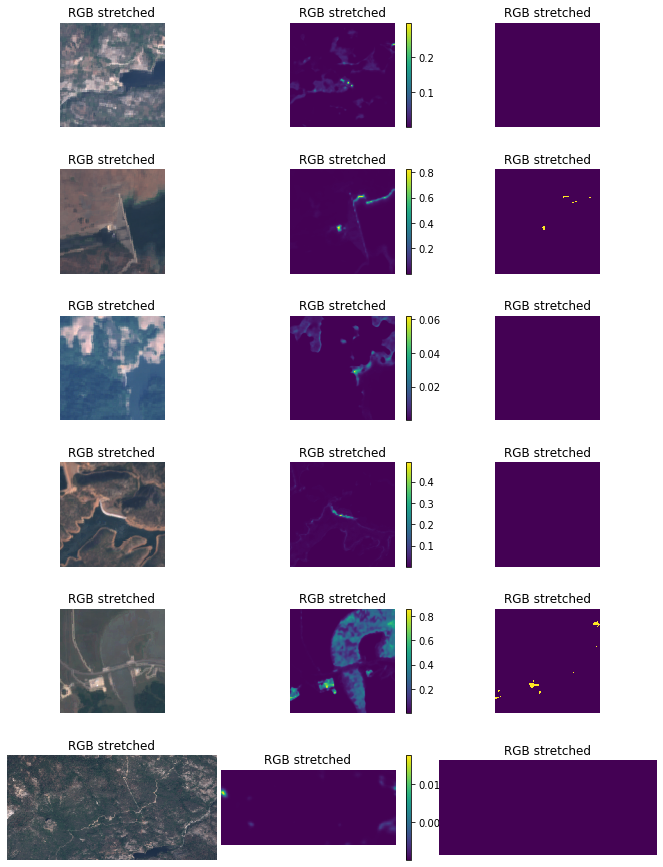

In [16]:
# ADD AVE/NDWI heatmaps?
data = iter(dataset)
columns = 3
rows = len(images)

fig = plt.figure(figsize=(columns+8, rows+5))
gs = gridspec.GridSpec(rows, columns,
        wspace=0.0, hspace=0.4, 
        top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
        left=0.5/(columns+1), right=1-0.2/(columns+1)) 

for j,x in enumerate(images):
    img_features = next(iter(x))
    full_image = stitch_patches(img_features,mixers[j])
    
    print(full_image.shape)
    
    preds = model.predict(full_image[np.newaxis,:,:,0:5])
    mask = preds[0,:,:,1] > 0.5
    
    # plot the original image (3 channels)
    ax = plt.subplot(gs[j,0])
    ax.set_title("RGB stretched")
    ax.imshow(np.fliplr(np.rot90(full_image[:,:,0:3], k=3)))
    plt.axis('off')

    # Plot dam probability heatmap
    ax = plt.subplot(gs[j,1])
    ax.set_title("RGB stretched")
    im = ax.imshow(np.fliplr(np.rot90(preds[0,:,:,1], k=3)), 
              cmap='viridis', 
              interpolation='nearest')
    fig.colorbar(im,ax=ax)

    plt.axis('off')
    
    # plot dam thresholds
    ax = plt.subplot(gs[j,2])
    ax.set_title("RGB stretched")
    ax.imshow(np.fliplr(np.rot90(mask, k=3)), 
              cmap='viridis', 
              interpolation='nearest')
    plt.axis('off')
    

## Confusion matrices
Tmux and sacred do not go together



In [48]:
from models.densenet import build_densenet121_imagenet, build_densenet121
from models.resnet import build_resnet50, build_resnet50_imagenet
from datasets.load_data import load_data
from generators.tf_parsing import validate

model_params = {'channels': ['B4', 'B3', 'B2', 'NDWI', 'AVE'],
				'target_size': [128, 128],
				'num_classes': 2}

x_train, y_train, x_val, y_val, x_test, y_test, probs = load_data(bridge_separate=True)
test_dataset = validate(x_test, 32, bridge_separate=True, stretch_colorspace=True, **model_params)

 EXTRACTING DATA FROM: /vol/tensusers2/sdooper/dam_detection/datasets 

Counter({'other': 325, 'good': 256, 'grand': 58, 'bridges': 30})
DATA    |  NUMBER OF TFRECORDS             
-------------------------------------
bridges |            41
grand    |           73
good   |             323
other   |            411
-------------------------------------
TOTAL   |            848 

Train, validation, and test split distribution: 

SPLIT       |  NUMBER OF TFRECORDS   
-------------------------------------
training    |        669
validation  |        9
test        |        170
-------------------------------------
TOTAL       |        848 

class probabilities in training set are: {'dams': 0.4693572496263079, 'bridges': 0.04484304932735426, 'other': 0.4857997010463378}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [120]:
import re
models = {'resnet50': build_resnet50,
          'resnet50_imagenet':build_resnet50_imagenet,
          'densenet121':build_densenet121,
          'densenet121_imagenet': build_densenet121_imagenet}
        
labels = [label for img,label in test_dataset]
labels = [np.argmax(item.numpy()) for sublist in labels for item in sublist]
labels = np.array(labels)

for key,values in models.items():
    print("predicting confusion matrix for {}".format(key))
    prog = re.compile("resnet|densenet")
    folder = prog.findall(key)
    weight_list = glob('checkpoints/{}/model-{}-*.hdf5'.format(folder[0],key))
    for weights in weight_list:
        print("predicting weights for {}".format(weights[-8:-5]))
        num_classes = weights[-8]
        # only need the length of the channels, not the actual names
        num_channels = list(range(0,int(weights[-6])))
        model = values(train_model=True, **{'num_classes': int(num_classes),
                                            'channels':num_channels})
        model.load_weights(weights)
        
        preds = model.predict(test_dataset)

        confusion_matrix = tf.math.confusion_matrix(labels, np.argmax(preds, axis=1))
        print(confusion_matrix)
        
    

predicting confusion matrix for resnet50
predicting weights for 3-5
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 5 0           input_41[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 15744       conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_______________________

tf.Tensor(
[[6749 1530   21]
 [  65 7479  356]
 [   7  165  628]], shape=(3, 3), dtype=int32)
predicting weights for 3-4
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 4 0           input_42[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 12608       conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv

ValueError: Error when checking input: expected input_42 to have shape (None, None, 4) but got array with shape (128, 128, 5)